In [1]:
import pandas as pd
import itertools
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import utils.helpers as hp
import model.queries as qrs

sns.set_theme(style="whitegrid")



### Check packet loss measures to the problematic site INFN-ROMA1

In [2]:
site = 'INFN-ROMA1'

dt = hp.GetTimeRanges('2021-01-14 07:00','2021-02-01 07:00')
pl = qrs.getMeasures(dt, 'dest_site', site, 'ps_packetloss')

pl.head()

,packet_loss,src,dest_site,ipv6,dest_host,src_host,dest,src_site,timestamp,dt
0,0.0,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649286000,2021-01-26 08:21:26
1,0.0,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649346000,2021-01-26 08:22:26
2,0.0,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649357000,2021-01-26 08:22:37
3,0.0,2001:660:5310:420::2,INFN-ROMA1,True,perfsonar2.roma1.infn.it,lapp-ps02.in2p3.fr,2001:760:422c:35::18,IN2P3-LAPP,1611649587000,2021-01-26 08:26:27
4,1.0,2001:630:40:ef::7c,INFN-ROMA1,True,perfsonar2.roma1.infn.it,ps002.gla.scotgrid.ac.uk,2001:760:422c:35::18,UKI-SCOTGRID-GLASGOW,1610987619000,2021-01-18 16:33:39


#### Get packetloss data

In [3]:
from model.DataLoader import GeneralDataLoader

meta = GeneralDataLoader()

selIPs = pl['src'].unique()
dest_site = 'INFN-ROMA1'
destips = meta.pls[meta.pls['site'] == dest_site]['ip'].to_list()
print()
print(f'{dest_site} uses the following IPs for measuring packet loss {destips}')
print()


sdatalist = []
plossdict = {}
for src, dest in list(itertools.product(selIPs, destips)):
    data = qrs.getMeasures(dt, 'src', src, 'ps_packetloss', 'dest', dest)
    if data is not None:
        sdatalist.append(data)
        print(src, len(data))
        plossdict[data['src'].unique()[0]] = data

# plossdict

OBJECT DOES NOT EXIST <class 'model.DataLoader.GeneralDataLoader'> 2021-02-13 13:00 2021-02-16 13:00
 >>> CREATING NEW INSTANCE
Query  ps_packetloss  for the period 1613221200000 - 1613480400000
Finished 'BuildDataFrame' in 6.0784 secs
Query  ps_owd  for the period 1613221200000 - 1613480400000
Finished 'BuildDataFrame' in 5.4075 secs
Query  ps_throughput  for the period 1613221200000 - 1613480400000
Finished 'BuildDataFrame' in 2.8091 secs
Query  ps_retransmits  for the period 1613221200000 - 1613480400000
Finished 'BuildDataFrame' in 3.4715 secs
Query  ps_trace  for the period 1613221200000 - 1613480400000
Finished 'BuildDataFrame' in 3.9222 secs
Finished 'UpdateGeneralInfo' in 23.8788 secs
OBJECT EXISTS <class 'model.DataLoader.GeneralDataLoader'> 2021-02-13 13:00 2021-02-16 13:00
OBJECT EXISTS <class 'model.DataLoader.GeneralDataLoader'> 2021-02-13 13:00 2021-02-16 13:00

INFN-ROMA1 uses the following IPs for measuring packet loss ['141.108.35.18', '2001:760:422c:35::18']

2001:660

#### Get traceroute data

In [5]:
#get all traceroute data for each of the IPs showing issues with INFN-ROMA1
tracedict, tracedflist = {}, []
for src, dest in list(itertools.product(selIPs, destips)):   
    data = qrs.getTraceroute('src', src, 'dest', dest, dt)
    if data is not None:
#         print(src, len(data))
        tracedict[src] = data
        tracedflist.append(data)  

### Calculate the mean packetloss for each path using the periods between traceroute measures

In [97]:
def calculatePathLoss(trace_df):
    # sort data before calculating
    trace_df = trace_df.sort_values('timestamp', ascending=True)
    # get the previous row value
    trace_df['dt_prev'] = trace_df.dt.shift(1)
    trace_df['route-sha1_prev'] = trace_df['route-sha1'].shift(1)
    
    src = trace_df['src'].unique()[0]
    dest = trace_df['dest'].unique()[0]
    
    # extract only the src-dest data
    loss = plossdict[src][plossdict[src]['dest']==dest]


    def calcLoss(row):
        ploss = loss[(loss['dt']<=row['dt']) & 
                     (loss['dt']>=row['dt_prev']) &
                     (loss['ipv6']==row['ipv6'])]['packet_loss'].mean()
        lossList = loss[(loss['dt']<=row['dt']) & 
                    (loss['dt']>=row['dt_prev']) &
                    (loss['ipv6']==row['ipv6'])]['packet_loss'].to_list()
        bl, zl = 0, 0
        if len(lossList)>0:
            cnt, total = 0, 0
            for i in lossList:
                if i <= 0.01:
                    cnt+=1
                total+=1
            zl = round(cnt/total,2) if total>0 else 0

        if len(lossList)>0:
            cnt, total = 0, 0
            for i in lossList:
                if i > 0.1:
                    cnt+=1
                total+=1
            bl = round(cnt/total,2) if total>0 else 0

        pathChanged = 1
        if row['route-sha1'] == row['route-sha1_prev']:
            pathChanged = 0

        return pd.Series([ploss, pathChanged, bl, zl])

    trace_df[['loss', 'path_changed', 'big_loss', 'zero_loss']] = trace_df.apply(calcLoss, axis=1)

    trace_df = trace_df[['push', 'MA', 'src', 'dest', 'src_host', 'dest_host', 'ipv6',
           'src_site', 'src_VO', 'dest_site', 'dest_VO', 'src_production',
           'dest_production', 'timestamp', 'hops', 'asns', 'rtts', 'ttls',
           'n_hops', 'max_rtt', 'destination_reached', 'route-sha1',
           'path_complete', 'looping', 'dt_prev', 'dt', 'route-sha1_prev', 'loss',
           'path_changed', 'big_loss', 'zero_loss']]

    return trace_df

i = 0
for df in tracedflist:
    tracedflist[i] = calculatePathLoss(df)
    i+=1

#### Merge all dataframes into one

In [99]:
mergedDf = pd.DataFrame()
for df in tracedflist:
    mergedDf = mergedDf.append(df)
    
mergedDf.reset_index(inplace=True)
# remove rows with null loss values
mergedDf = mergedDf[mergedDf['loss'].isnull() == False]
# remove rows when path is unknown
mergedDf = mergedDf[mergedDf['path_changed'] == 0]
mergedDf.reset_index(inplace=True)
print(len(mergedDf))

mergedDf.head()

12781


,level_0,index,push,MA,src,dest,src_host,dest_host,ipv6,src_site,...,route-sha1,path_complete,looping,dt_prev,dt,route-sha1_prev,loss,path_changed,big_loss,zero_loss
0,7,779,False,2001:660:5310:420::2,2001:660:5310:420::2,2001:760:422c:35::18,lapp-ps02.in2p3.fr,perfsonar2.roma1.infn.it,True,IN2P3-LAPP,...,ecffb2f98014b30883371b4833edd07b43efb06f,False,False,2021-01-14 09:48:59,2021-01-14 09:56:30,ecffb2f98014b30883371b4833edd07b43efb06f,0.000702,0.0,0.0,1.0
1,10,336,False,2001:660:5310:420::2,2001:660:5310:420::2,2001:760:422c:35::18,lapp-ps02.in2p3.fr,perfsonar2.roma1.infn.it,True,IN2P3-LAPP,...,ecffb2f98014b30883371b4833edd07b43efb06f,False,False,2021-01-14 10:07:31,2021-01-14 10:16:43,ecffb2f98014b30883371b4833edd07b43efb06f,0.000444,0.0,0.0,1.0
2,11,614,False,2001:660:5310:420::2,2001:660:5310:420::2,2001:760:422c:35::18,lapp-ps02.in2p3.fr,perfsonar2.roma1.infn.it,True,IN2P3-LAPP,...,ecffb2f98014b30883371b4833edd07b43efb06f,False,False,2021-01-14 10:16:43,2021-01-14 10:28:46,ecffb2f98014b30883371b4833edd07b43efb06f,0.000778,0.0,0.0,1.0
3,28,752,False,2001:660:5310:420::2,2001:660:5310:420::2,2001:760:422c:35::18,lapp-ps02.in2p3.fr,perfsonar2.roma1.infn.it,True,IN2P3-LAPP,...,ecffb2f98014b30883371b4833edd07b43efb06f,False,False,2021-01-14 12:10:17,2021-01-14 12:16:46,ecffb2f98014b30883371b4833edd07b43efb06f,0.001000,0.0,0.0,1.0
4,53,720,False,2001:660:5310:420::2,2001:660:5310:420::2,2001:760:422c:35::18,lapp-ps02.in2p3.fr,perfsonar2.roma1.infn.it,True,IN2P3-LAPP,...,ecffb2f98014b30883371b4833edd07b43efb06f,False,False,2021-01-14 14:56:11,2021-01-14 15:07:19,ecffb2f98014b30883371b4833edd07b43efb06f,0.001032,0.0,0.0,1.0


#### Transform each hop into a column and True/False to indicate the usage of the hop

In [8]:
dfh = pd.get_dummies(mergedDf['hops'].apply(pd.Series).stack(), prefix='hop').sum(level=0)
hops = dfh.join(mergedDf[['route-sha1', 'destination_reached', 'path_complete', 'looping', 'loss', 'big_loss', 'zero_loss']])
hops[["destination_reached", "path_complete", "looping"]] = hops[["destination_reached", "path_complete", "looping"]].astype(int)

hops

,hop_10.255.255.2,hop_130.206.206.153,hop_131.154.254.2,hop_131.169.197.158,hop_131.169.7.15,hop_134.158.84.129,hop_134.219.225.1,hop_140.181.2.1,hop_141.108.35.18,hop_144.206.236.253,...,hop_fd2a:62b:3c2c:cbc2:1:9:9:2,hop_fd2a:62b:3c2c:cbc2:4:ff:ff:f2,hop_fd74:19b:0:4002::2,route-sha1,destination_reached,path_complete,looping,loss,big_loss,zero_loss
0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,ecffb2f98014b30883371b4833edd07b43efb06f,0,0,0,0.000702,0.0,1.0
1,1,0,0,0,0,1,0,0,1,0,...,0,0,0,ecffb2f98014b30883371b4833edd07b43efb06f,0,0,0,0.000444,0.0,1.0
2,1,0,0,0,0,1,0,0,1,0,...,0,0,0,ecffb2f98014b30883371b4833edd07b43efb06f,0,0,0,0.000778,0.0,1.0
3,1,0,0,0,0,1,0,0,1,0,...,0,0,0,ecffb2f98014b30883371b4833edd07b43efb06f,0,0,0,0.001000,0.0,1.0
4,1,0,0,0,0,1,0,0,1,0,...,0,0,0,ecffb2f98014b30883371b4833edd07b43efb06f,0,0,0,0.001032,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12776,0,0,0,0,0,0,0,0,1,0,...,0,0,0,4bbdb51321eddd4d86c2cd53bc8fa755351fe103,1,0,0,1.000000,1.0,0.0
12777,0,0,0,0,0,0,0,0,1,0,...,0,0,0,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,1,0,0,1.000000,1.0,0.0
12778,0,0,0,0,0,0,0,0,1,0,...,0,0,0,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,1,0,0,1.000000,1.0,0.0
12779,0,0,0,0,0,0,0,0,1,0,...,0,0,0,f4f48c9df38acebae3d2fe9377b6c90a7499e7ce,1,0,0,1.000000,1.0,0.0


#### Now let's find the mean loss based on a hop. This should highligh the most problematic hops 

In [ ]:
# Example

print(hops.groupby('hop_145.100.0.157').agg({'loss': 'mean'}))

print(hops.groupby('hop_134.219.225.1').agg({'loss': 'mean'}))

In [11]:
hopsdf = pd.DataFrame()
hopsDict = {}
for col in hops.columns[:-7]:
    data = hops.groupby(col).agg({'loss': 'mean'}).to_dict()
    hopsDict[col] = data["loss"]

# add everything to a dataframe
hopsdf = pd.DataFrame.from_dict({(i): hopsDict[i]
                           for i in hopsDict.keys()},
                       orient='index')

hopsdf.head()

,0,1,2
hop_10.255.255.2,0.428975,0.000596,NaN
hop_130.206.206.153,0.420991,0.001801,NaN
hop_131.154.254.2,0.464765,0.000665,NaN
hop_131.169.197.158,0.442457,0.000591,NaN
hop_131.169.7.15,0.431392,0.000539,NaN


#### Remove the destination column
If the destination is reached, then the list of hops includes the last one which is the destination itself, but the route-sha1 is the same with or wothout that last jop.This creates issues when we check for similarity

In [12]:
print('all columns', len(hops.columns))
hops_cols_minus_dest = [col for col in hops.columns if col not in [f'hop_{destips[0]}', f'hop_{destips[1]}']]
print('hops_cols_minus_dest columns', len(hops_cols_minus_dest))

hops_df_minus_dest = hops[hops_cols_minus_dest]

all columns 227
hops_cols_minus_dest columns 225


#### Get each hop and sum all packet loss it received for each measure in the dataset

In [129]:
hashDf = hops_df_minus_dest.groupby('route-sha1').agg({'loss': 'mean'}).reset_index()
Df = pd.merge(hops_df_minus_dest[hops_df_minus_dest.columns[:-6]], hashDf).drop_duplicates()


def markHops(row):
    for col in row.keys():
        if col != 'route-sha1':
            if row[col] in [1,2]:
                row[col] = hops_df_minus_dest[hops_df_minus_dest[col].isin([1,2])]['loss'].sum()
            else: row[col] = ''

    return row

            
tagDf = Df.apply(lambda x: markHops(x), axis=1)

tagDf = tagDf.drop(columns='loss')
tagDf = tagDf.set_index('route-sha1')

fig = go.Figure(go.Heatmap(z=tagDf.values, x=tagDf.columns, y=tagDf.index, xgap=1, colorscale='portland'))

fig.update_layout(title='Sum all packet loss for each hop' , template='plotly_white')
py.offline.plot(fig)

# see hops_tagging.png

'temp-plot.html'

<AxesSubplot:xlabel='score', ylabel='Count'>

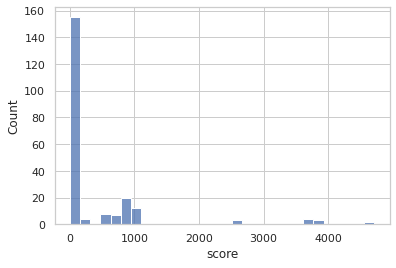

In [57]:
d = []
for col in tagDf.columns:
    d.append({'hop': col, 'score':hops_df_minus_dest[hops_df_minus_dest[col].isin([1,2])]['loss'].sum()})

scoreDf = pd.DataFrame(d)
scoreDf

sns.histplot(data=scoreDf, x="score",bins=30,stat='count')

In [29]:
def getLoss(row):
    for col in row.keys():
        if col not in ['route-sha1', 'loss']:
            if row[col] in [1,2]:
                row[col] = row['loss']
            else: row[col] = np.nan
        
    return row
            
lossMrtx = Df.apply(lambda x: getLoss(x), axis=1)

lossMrtx = lossMrtx.drop(columns='loss')
lossMrtx = lossMrtx.set_index('route-sha1')


fig = go.Figure(go.Heatmap(z=lossMrtx.values, x=lossMrtx.columns, y=lossMrtx.index, xgap=1, coloraxis = "coloraxis"))

fig.update_layout(title='Mean packetloss for each hash' , template='plotly_white')
py.offline.plot(fig)

# see path_mean_loss.png

'temp-plot.html'

#### Find the similarity coefficient between paths

In [31]:
from scipy.spatial.distance import hamming

pathRange = hops_df_minus_dest['route-sha1'].unique()

vectors = hops_df_minus_dest[(hops_df_minus_dest['route-sha1'].isin(pathRange))][hops_df_minus_dest.columns[:-7]].drop_duplicates().values

print(len(vectors))

simList = []

for i in range(len(vectors)):
    temp = {}
    for j in range(len(vectors)):
        # dist==0 means the paths have nothing in common, while dist==1 means the paths are the same
        dist = 1-hamming(vectors[i], vectors[j])
        loss = hops[hops['route-sha1']==pathRange[j]].groupby('route-sha1').agg({'loss': 'mean'}).to_dict()
        simList.append([pathRange[i], pathRange[j], dist, loss['loss'][pathRange[j]]])


simDf = pd.DataFrame(simList, columns=['hash1', 'hash2', 'similarity', 'avg_loss_hash2'])
simDf.head()

115


,hash1,hash2,similarity,avg_loss_hash2
0,ecffb2f98014b30883371b4833edd07b43efb06f,ecffb2f98014b30883371b4833edd07b43efb06f,1.000000,0.000549
1,ecffb2f98014b30883371b4833edd07b43efb06f,e808d8359a863fb1b65d0810015bdb31ad72b75a,0.990826,0.000659
2,ecffb2f98014b30883371b4833edd07b43efb06f,bb70d61f7980b0370a5fb9f6f4071cffefaaa694,0.912844,0.000974
3,ecffb2f98014b30883371b4833edd07b43efb06f,305d64012aabb53c853b88631b49ecce4f1ca5ec,0.912844,0.001494
4,ecffb2f98014b30883371b4833edd07b43efb06f,ccf688771664f878931fa2324b66ac5ce3fd75d8,0.880734,0.915956


#### Initial version of a method to find very simmilar paths (differing by 1 or 2 hops) and big change in packet loss.
This could signify an issue with a specific hop or two without complicated calculations. Perhaps it could better work of short periods. To be tested

In [67]:
def immediateIssues(x):
    flag = 0
    idx = 0
    for k, v in x.items():
#         print(k)
        if k == 'avg_loss_hash2':
#             print(v)
            for i, value in v.items():
                
                if i != x.index[0]:
                    diff = np.abs(value - v[i-1])
#                     print(test.iloc[i]['similarity'])
                    if diff > 0.5 and test.iloc[i]['similarity'] > 0.95:
                        flag = 1
                        return test.iloc[i][['hash1', 'hash2', 'similarity', 'avg_loss_hash2']]

test = simDf.sort_values(['hash1', 'similarity'], ascending=False).reset_index(drop=True)
# test = test[:30]
bigDiff = test.groupby(['hash1']).apply(lambda x: immediateIssues(x)).reset_index(drop=True)
bigDiff.dropna(inplace=True)
bigDiff

""


### Show the similarity plot for a specific hash

In [64]:
# res = hops[(hops.index==188) | (hops.index==0)][res.columns[:-7]]
# paths = hops[(hops.index==188) | (hops.index==0)]['route-sha1']

hash1 = '646a17ec4f838669ad6f2f56672eac9f713ca229'
paths = simDf[simDf['hash1']==hash1].sort_values('similarity', ascending=False)['hash2'].to_list()[:5]
paths.append(hash1)
res =  hops[(hops['route-sha1'].isin(paths)) & (hops['destination_reached']==True)][hops.columns[:-7]].drop_duplicates()

## fix that
loss = bigDiff[bigDiff['hash1']==hash1].sort_values('similarity', ascending=False)['avg_loss_hash2'].to_list()[:5]

title = mergedDf[mergedDf['route-sha1'].isin(paths)].groupby(['route-sha1', 'src', 'dest']).agg({'loss':'mean'}).reset_index()

def bool2string(A):
    #convert a binary array into an array of strings 'True' and 'False'
    S = np.empty(A.shape,  dtype=object)
    S[np.where(A)] = 'True'
    S[np.where(A==0)] = 'False'
    return S
clrs =[[0,  '#0000db'], #discrete colorscale to map 0 (False) to dark blue, and 1 (True) to red
       [1, '#b10000']]
       

df = res
groups = list(df.columns)


A = df.values


fig = go.Figure(go.Heatmap(z=A, x=groups, y=paths, xgap=1))


# fig.update_layout(title=f"{title['route-sha1'][0]}: {round(loss[0],2)}     {title['route-sha1'][1]}: {round(loss[1],2)}     {title['route-sha1'][2]}: {round(loss[2],2)}</br></br>{title['route-sha1'][3]}: {round(loss[3],2)}     {title['route-sha1'][4]}: {round(loss[4],2)} ",
#                       template = 'plotly_white')


py.offline.plot(fig)

'temp-plot.html'

#### Calculate some probability for each hop

In [126]:
import scipy.stats as st

hopsDict = {}
# for col in hops.columns[1:2]:
for col in hops.columns[:-7]:
    data = hops.groupby(col).agg({'loss': ['mean','std','skew'], 'route-sha1': 'nunique'})
    for i in data.index:
        if i > 0:
            mean = data["loss"]['mean'][i]
            std = data["loss"]['std'][i]
            skew = data["loss"]['skew'][i]
            cnt =  data['route-sha1']['nunique'][i]
    
    z = (0.9 - mean) / std
    
    hopsDict[col] = {'mean': mean, 'std': std, 'skew': skew, 'P': round(st.norm.cdf(1-z), 2), 'unique_paths':cnt}
#     print(hops.groupby(col).agg({'loss': 'mean'}).to_dict())

# hopsDict

dfStats = pd.DataFrame.from_dict({(i): hopsDict[i]
                           for i in hopsDict.keys()},
                       orient='index')

dfStats

,mean,std,skew,P,unique_paths
hop_10.255.255.2,0.000596,0.001290,7.135742,0.00,2
hop_130.206.206.153,0.001801,0.003744,4.576340,0.00,2
hop_131.154.254.2,0.000665,0.001303,8.263070,0.00,2
hop_131.169.197.158,0.000591,0.000895,3.008316,0.00,5
hop_131.169.7.15,0.000539,0.000811,2.969908,0.00,2
...,...,...,...,...,...
hop_90.147.80.18,0.919267,0.068947,-10.255017,0.90,6
hop_90.147.80.6,0.000930,0.003619,12.988968,0.00,29
hop_fd2a:62b:3c2c:cbc2:1:9:9:2,0.917091,0.040566,-0.428865,0.92,2
hop_fd2a:62b:3c2c:cbc2:4:ff:ff:f2,0.917091,0.040566,-0.428865,0.92,2


#### Add the rpobability to a matrix in order to show the heatmap

In [127]:
Df = hops_df_minus_dest[hops_df_minus_dest.columns[:-6]].drop_duplicates()

def markHops(row):
    for col in row.keys():
        if col != 'route-sha1':
            if row[col] in [1,2]:
                if len(dfStats[dfStats.index == col]['P'].values)==0:
                    print(col, dfStats[dfStats.index == col]['P'].values)
                row[col] = dfStats[dfStats.index == col]['P'].values[0]
            else: row[col] = ''

    return row

            
probDf = Df.apply(lambda x: markHops(x), axis=1)
probDf
# probDf = tagDf.drop(columns='loss')
probDf = probDf.set_index('route-sha1')

fig = go.Figure(go.Heatmap(z=probDf.values, x=probDf.columns, y=probDf.index, xgap=1, colorscale='portland'))

fig.update_layout(title='The probablity a hop gets >1% packetloss' , template='plotly_white')
py.offline.plot(fig)

# see hops_probability.png

'temp-plot.html'